In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

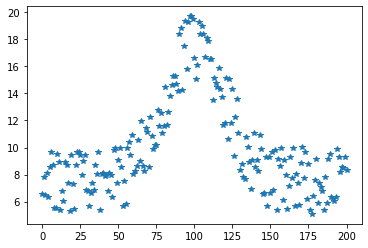

In [2]:
#Lets Try GP on a gaussian random set of points
def gaussian(mu,sigma,norm,offset):
    """Returns a gaussian function with the given parameters"""
    return lambda x: norm*np.exp(-(1./2.)*((x-mu)/(sigma))**2)+offset

Xin = np.mgrid[0:201] # points from 0 to 201
data = gaussian(100., 20., 10., 5)(Xin) + 5*np.random.random(Xin.shape) # Guassian + semaring
plt.plot(data,"*")

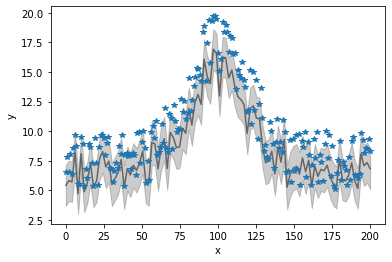

In [3]:
#now lets run GP on this guy
import george
from george import kernels
kernel = np.var(data) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
var=np.ones(len(Xin))*2
gp.compute(Xin,var)
x_pred = np.linspace(0, 200, 100)
pred, pred_var = gp.predict(data, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.plot(Xin,data,"*")
plt.xlabel("x")
plt.ylabel("y");

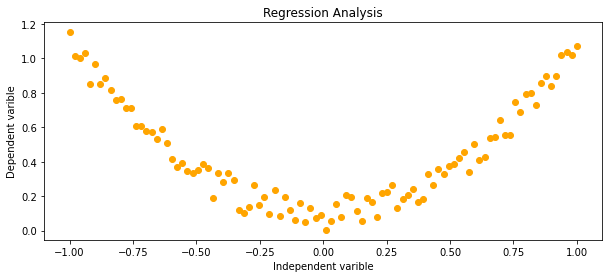

In [4]:
torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()


Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


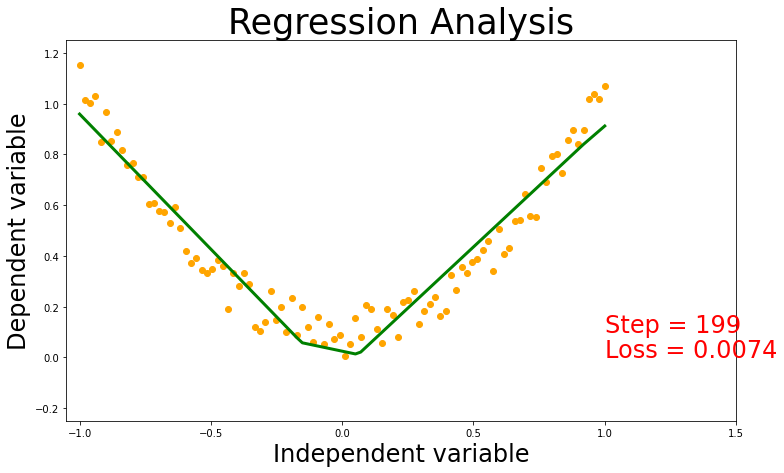

In [5]:
# this is one way to define a network
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

my_images = []
fig, ax = plt.subplots(figsize=(12,7))
# train the network
for t in range(200):
  
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    # plot and show learning process
    plt.cla()
    ax.set_title('Regression Analysis', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.set_xlim(-1.05, 1.5)
    ax.set_ylim(-0.25, 1.25)
    ax.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
    ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
    ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
    ax.text(1.0, 0, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'}) 
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    my_images.append(image)
imageio.mimsave('./curve_1.gif', my_images, fps=10)

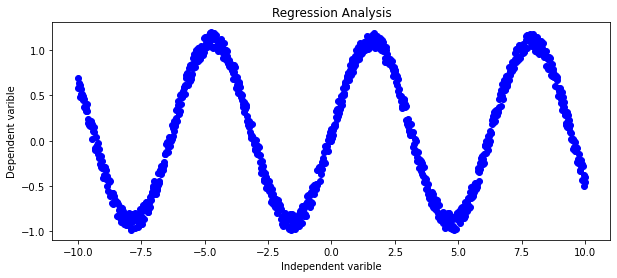

In [21]:
torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)  # x data (tensor), shape=(100, 1)
y = torch.sin(x) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "blue")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig('curve_2.png')
plt.show()

In [7]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        #torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

In [ ]:
#Skip me batch training
BATCH_SIZE = 64
EPOCH = 200
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=2,)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
# start training
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        prediction = net(b_x)  
        loss = loss_func(prediction, b_y)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        

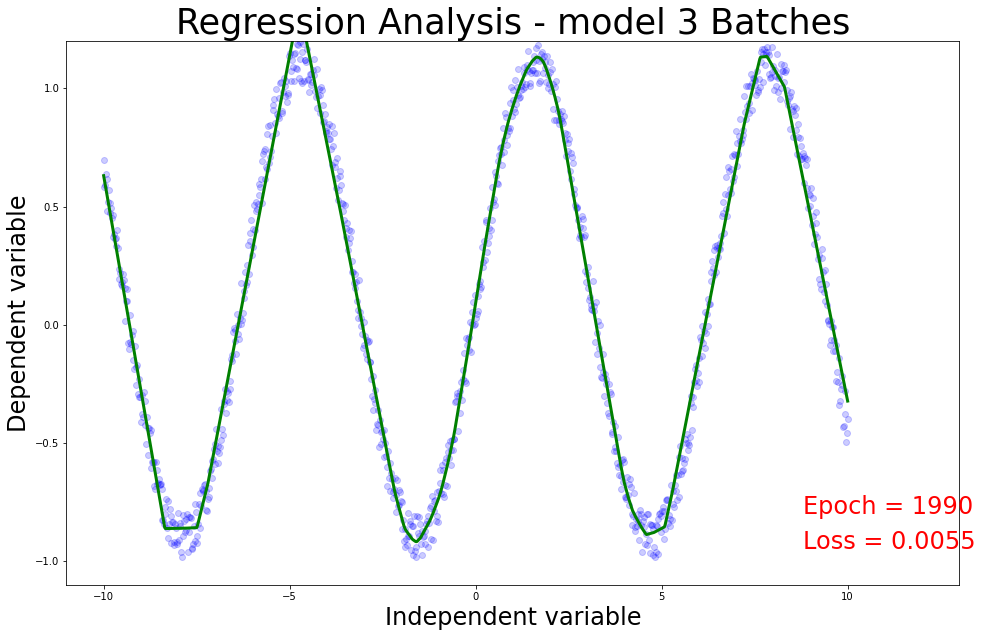

In [8]:
EPOCH = 2000
torch_dataset = Data.TensorDataset(x, y)
#loader = Data.DataLoader(dataset=torch_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=2,)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
# start training
for epoch in range(EPOCH):
    prediction = net(x)
    loss = loss_func(prediction, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    if epoch % 10 == 0:
        # plot and show learning process
        plt.cla()
        ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
        ax.set_xlabel('Independent variable', fontsize=24)
        ax.set_ylabel('Dependent variable', fontsize=24)
        ax.set_xlim(-11.0, 13.0)
        ax.set_ylim(-1.1, 1.2)
        ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue", alpha=0.2)
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
        ax.text(8.8, -0.8, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# save images as a gif    
imageio.mimsave('./curve_2_model_3_batch.gif', my_images, fps=12)

tensor([[ 6.5592],
        [ 7.7865],
        [ 6.5241],
        [ 8.1061],
        [ 6.3510],
        [ 8.5565],
        [ 9.6876],
        [ 8.7310],
        [ 5.5352],
        [ 5.5590],
        [ 9.4962],
        [ 8.9015],
        [ 5.3940],
        [ 6.7688],
        [ 6.0810],
        [ 8.9427],
        [ 8.6760],
        [ 7.3437],
        [ 5.3410],
        [ 9.4343],
        [ 7.3311],
        [ 5.4795],
        [ 8.6807],
        [ 9.6413],
        [ 9.6369],
        [ 9.4381],
        [ 7.9952],
        [ 8.9751],
        [ 9.4772],
        [ 6.8684],
        [ 6.7906],
        [ 5.6650],
        [ 6.6496],
        [ 7.3455],
        [ 6.8958],
        [ 8.7372],
        [ 8.0475],
        [ 9.6834],
        [ 5.4030],
        [ 8.0141],
        [ 8.1275],
        [ 7.9199],
        [ 7.9516],
        [ 6.7649],
        [ 8.1382],
        [ 7.9651],
        [ 6.3316],
        [ 9.8057],
        [ 9.9501],
        [ 7.3435],
        [ 9.0497],
        [ 9.9745],
        [ 8.

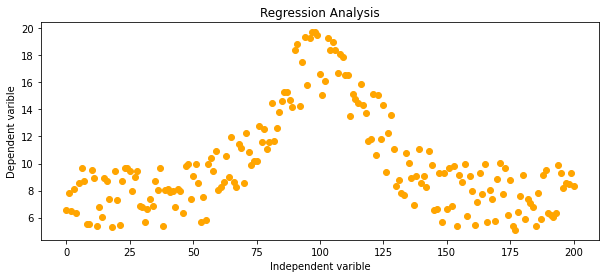

In [45]:
torch.manual_seed(1)    # reproducible

x=torch.unsqueeze(torch.linspace(0, 200, 201), dim=1) 
y=torch.from_numpy(data.reshape(len(data),1).astype('float32'))

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()


In [55]:
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(10, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

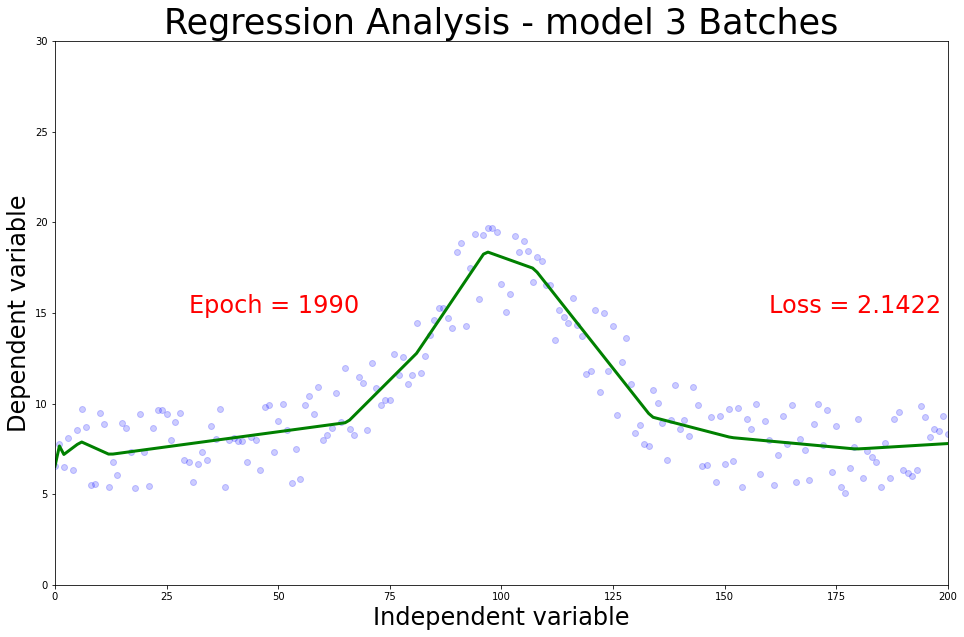

In [56]:
EPOCH = 2000
torch_dataset = Data.TensorDataset(x, y)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
for epoch in range(EPOCH):
    prediction = net(x)
    loss = loss_func(prediction, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    if epoch % 10 == 0:
        # plot and show learning process
        plt.cla()
        ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
        ax.set_xlabel('Independent variable', fontsize=24)
        ax.set_ylabel('Dependent variable', fontsize=24)
        ax.set_xlim(0, 200)
        ax.set_ylim(0, 30)
        ax.scatter(x.data.numpy(), y.data.numpy(), color = "blue", alpha=0.2)
        ax.plot(x.data.numpy(), prediction.data.numpy(), 'g-', lw=3)
        ax.text(30, 15, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(160,15, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# save images as a gif    
imageio.mimsave('./curve_gaus.gif', my_images, fps=12)

In [57]:
#now lets do a physics regression
import uproot
from collections import OrderedDict 
reg    = uproot.open("Regression2.root")["Tree"]

In [58]:
#what are the inputs
reg.keys()


[b'genpt1',
 b'geneta1',
 b'genphi1',
 b'genpt2',
 b'geneta2',
 b'genphi2',
 b'hpt',
 b'heta',
 b'hphi',
 b'hmass',
 b'part1pt1',
 b'part1eta1',
 b'part1phi1',
 b'part1id1',
 b'part1pt2',
 b'part1eta2',
 b'part1phi2',
 b'part1id2',
 b'part1pt3',
 b'part1eta3',
 b'part1phi3',
 b'part1id3',
 b'part1pt4',
 b'part1eta4',
 b'part1phi4',
 b'part1id4',
 b'part1pt5',
 b'part1eta5',
 b'part1phi5',
 b'part1id5',
 b'recopt1',
 b'recoeta1',
 b'recophi1',
 b'recomass1',
 b'part2pt1',
 b'part2eta1',
 b'part2phi1',
 b'part2id1',
 b'part2pt2',
 b'part2eta2',
 b'part2phi2',
 b'part2id2',
 b'part2pt3',
 b'part2eta3',
 b'part2phi3',
 b'part2id3',
 b'part2pt4',
 b'part2eta4',
 b'part2phi4',
 b'part2id4',
 b'part2pt5',
 b'part2eta5',
 b'part2phi5',
 b'part2id5',
 b'recopt2',
 b'recoeta2',
 b'recophi2',
 b'recomass2',
 b'recohpt',
 b'recoheta',
 b'recohphi',
 b'recohmass']

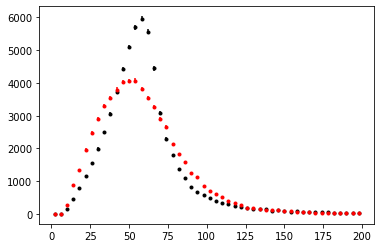

In [60]:
def plot(iVar,iMin,iMax,iColor): 
    mask=(reg.array(iVar) > 0)
    data=reg.array(iVar)[mask]
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    plt.errorbar(binCenters, counts, yerr=err,fmt="o",c=iColor,label="Data", ms=3)
    
plot("genpt1",0,200,"black")
plot("recopt1",0,200,"red")


In [61]:
#ok lets do a simple regression
# another way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(1, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

In [62]:
def plotax(iax,iVar,iMin,iMax,iColor): 
    mask=(reg.array(iVar) > 0)
    data=reg.array(iVar)[mask]
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    iax.errorbar(binCenters, counts, yerr=err,fmt="o",c=iColor,label="Data", ms=3)


torch.Size([62118, 1]) torch.Size([62118, 1])
Plotting 0
Plotting 10
Plotting 20
Plotting 30
Plotting 40
Plotting 50
Plotting 60
Plotting 70
Plotting 80
Plotting 90
Plotting 100
Plotting 110
Plotting 120
Plotting 130
Plotting 140
Plotting 150
Plotting 160
Plotting 170
Plotting 180
Plotting 190


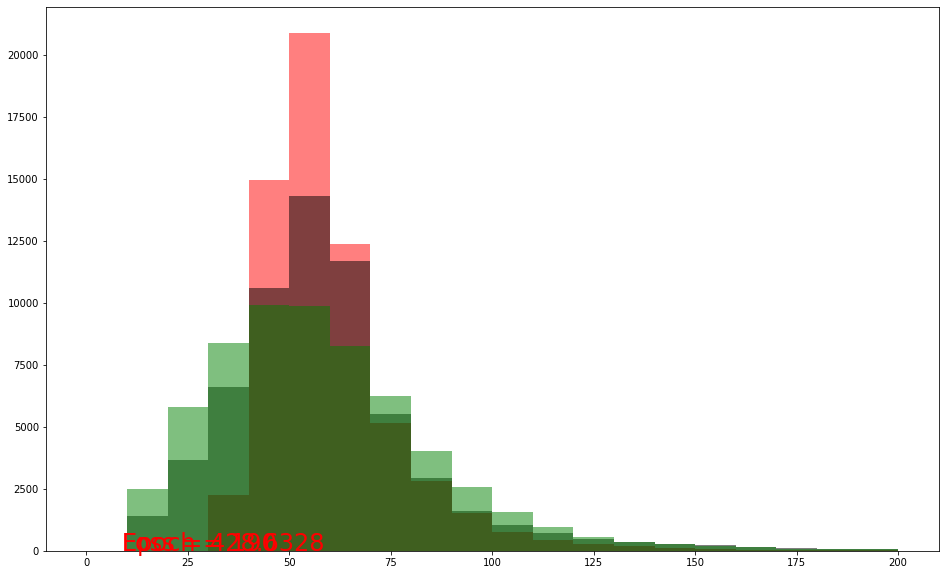

In [63]:
EPOCH = 200
BATCH_SIZE=100
mask1=(reg.array("genpt1") > 0)
mask2=(reg.array("recopt1") > 0)
mask = np.logical_and.reduce([mask1,mask2])
y=torch.from_numpy(reg.array("genpt1")[mask].reshape(len(reg.array("genpt1")[mask]),1))
x=torch.from_numpy(reg.array("recopt1")[mask].reshape(len(reg.array("recopt1")[mask]),1))
x, y = Variable(x), Variable(y)
#x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)
print(x.shape,y.shape)
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)
print(loader)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
# start training
for epoch in range(EPOCH):
    #for step, (batch_x, batch_y) in enumerate(loader):
    #    b_x = Variable(batch_x)
    #    b_y = Variable(batch_y)
    #    prediction = net(b_x)
    #    loss = loss_func(prediction, b_y)
    #    optimizer.zero_grad()
    #    loss.backward()
    #    optimizer.step()
    pred = net(x)
    loss = loss_func(pred, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    if epoch % 10 == 0:
        print("Plotting",epoch)
        # plot and show learning process
        plt.cla()
        ax.hist(pred.data.numpy(),color="red",bins=20,range=(0,200),alpha=0.5)
        ax.hist(y.data.numpy(),color="black" ,bins=20,range=(0,200),alpha=0.5)
        ax.hist(x.data.numpy(),color="green",bins=20,range=(0,200),alpha=0.5)
        ax.text(8.8, -0.8, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# save images as a gif    
imageio.mimsave('./reg1.gif', my_images, fps=12)

(array([   13.,   166.,   791.,  2980.,  7925., 11553., 10991.,  8046.,
         5347.,  3647.,  2648.,  1795.,  1329.,  1058.,   773.,   535.,
          463.,   333.,   290.,   228.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

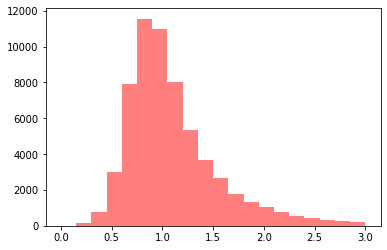

In [64]:
mask1=(reg.array("genpt1") > 0)
mask2=(reg.array("recopt1") > 0)
mask = np.logical_and.reduce([mask1,mask2])
#x=torch.from_numpy(reg.array("genpt1")[mask].reshape(len(reg.array("genpt1")[mask]),1))
#y=torch.from_numpy(reg.array("recopt0")[mask].reshape(len(reg.array("recopt0")[mask]),1))
#x, y = Variable(x), Variable(y)
true=reg.array("genpt1")[mask]
reco=reg.array("recopt1")[mask]
ratio=true/reco
plt.hist(ratio,color="red",bins=20,range=(0,3),alpha=0.5)

torch.Size([62118, 1]) torch.Size([62118, 1])
Plotting 0
(62118, 1) (62118,)
Plotting 10
(62118, 1) (62118,)
Plotting 20
(62118, 1) (62118,)
Plotting 30
(62118, 1) (62118,)
Plotting 40
(62118, 1) (62118,)
Plotting 50
(62118, 1) (62118,)
Plotting 60
(62118, 1) (62118,)
Plotting 70
(62118, 1) (62118,)
Plotting 80
(62118, 1) (62118,)
Plotting 90
(62118, 1) (62118,)
Plotting 100
(62118, 1) (62118,)
Plotting 110
(62118, 1) (62118,)
Plotting 120
(62118, 1) (62118,)
Plotting 130
(62118, 1) (62118,)
Plotting 140
(62118, 1) (62118,)
Plotting 150
(62118, 1) (62118,)
Plotting 160
(62118, 1) (62118,)
Plotting 170
(62118, 1) (62118,)
Plotting 180
(62118, 1) (62118,)
Plotting 190
(62118, 1) (62118,)


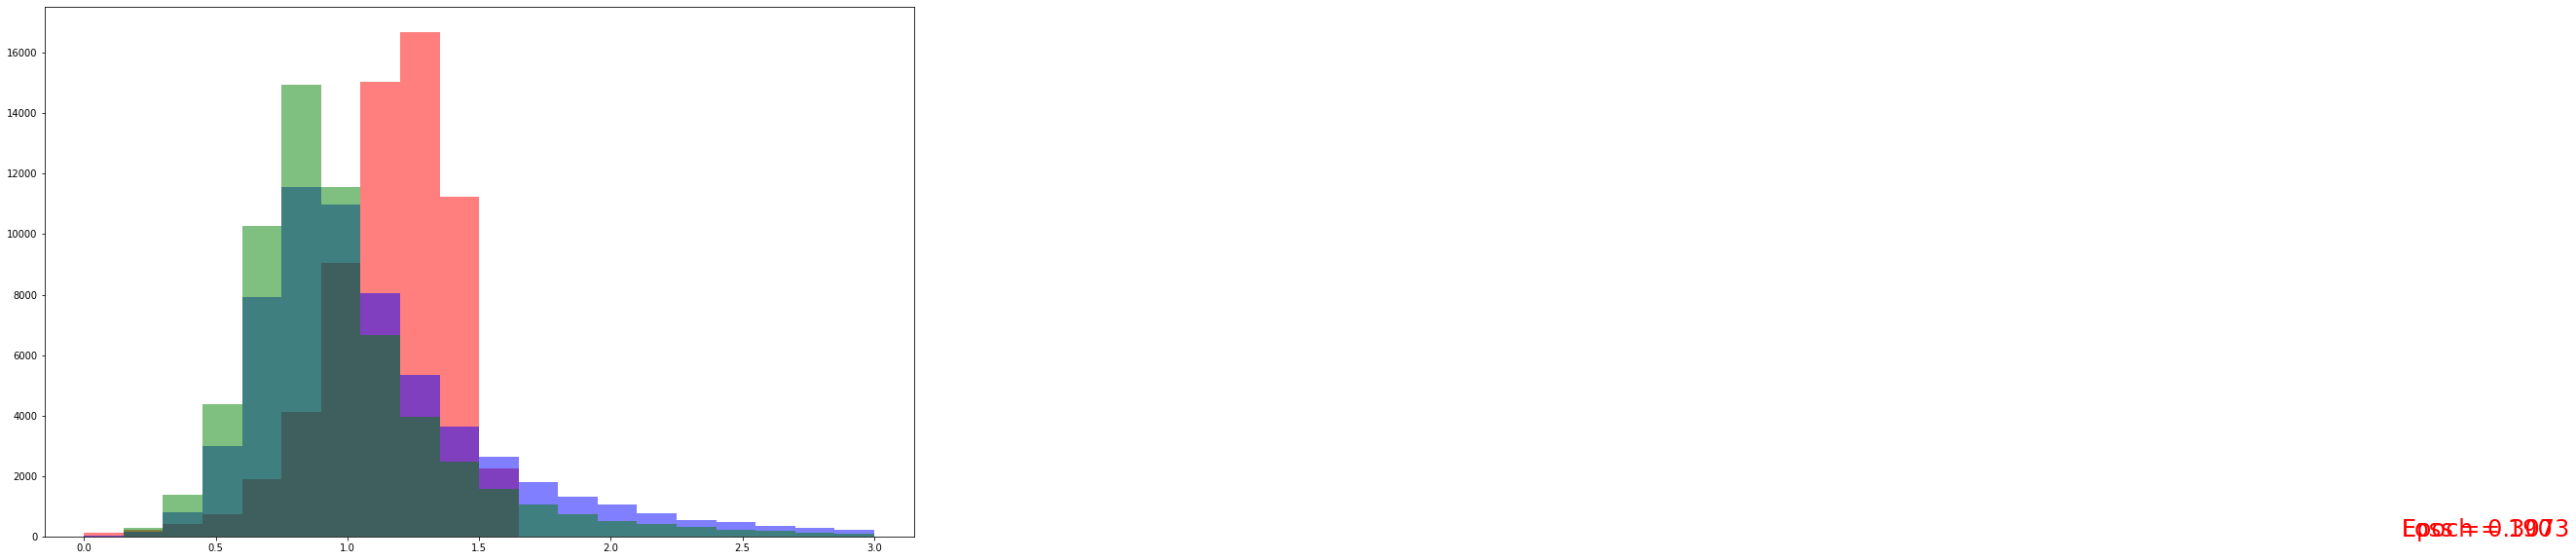

In [65]:
EPOCH = 200
BATCH_SIZE=100
y=torch.from_numpy(ratio.reshape(len(ratio),1))
y = Variable(y)
#x = torch.unsqueeze(torch.linspace(-10, 10, 1000), dim=1)
print(x.shape,y.shape)
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)
print(loader)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
# start training
for epoch in range(EPOCH):
    #for step, (batch_x, batch_y) in enumerate(loader):
    #    b_x = Variable(batch_x)
    #    b_y = Variable(batch_y)
    #    prediction = net(b_x)
    #    loss = loss_func(prediction, b_y)
    #    optimizer.zero_grad()
    #    loss.backward()
    #    optimizer.step()
    pred = net(x)
    loss = loss_func(pred, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    if epoch % 10 == 0:
        print("Plotting",epoch)
        # plot and show learning process
        plt.cla()
        corr = (x.data.numpy())*(pred.data.numpy())
        print(corr.shape,true.shape)
        ratio3=true.reshape(len(true),1)/corr
        ax.hist(pred.data.numpy(),color="red",bins=20,range=(0,3),alpha=0.5)
        ax.hist(y.data.numpy(),color="blue" ,bins=20,range=(0,3),alpha=0.5)
        ax.hist(ratio3,color="green",bins=20,range=(0,3),alpha=0.5)
        ax.text(8.8, -0.8, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# save images as a gif    
imageio.mimsave('./reg1.gif', my_images, fps=12)

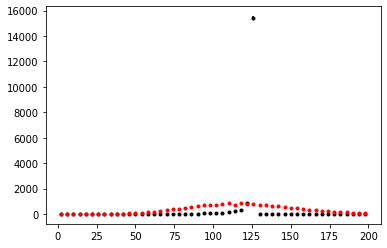

In [66]:
#now lets construct the higgs mass
plot("hmass",0,200,"black")
plot("recohmass",0,200,"red")

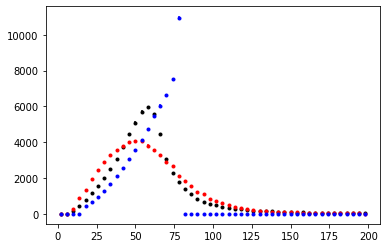

In [78]:
#Lets computed teh corrected pT
#Lets compute the mass on the fly
def ptcorr(iVec1,iNN):
    pt1 = torch.tensor([iVec1])
    corr1 = iNN(pt1).data.numpy()*iVec1
    return corr1

def plotcorr(iVar,iNN,iMin,iMax,iColor): 
    mask=(reg.array(iVar) > 0)
    data=reg.array(iVar)[mask]
    ptc = lambda iarr: ptcorr(iarr,net) 
    data = np.array([ptc(p) for p in data])
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    plt.errorbar(binCenters, counts, yerr=err,fmt="o",c=iColor,label="Data", ms=3)
    
plot("genpt1",0,200,"black")
plot("recopt1",0,200,"red")
plotcorr("recopt1",net,0,200,"blue")


(array([   0.,    0.,    0.,    0.,    3.,   18.,   38.,   85.,  153.,
         262.,  378.,  538.,  638.,  813., 1022., 1103., 1180., 1277.,
        1177., 1291., 1159., 1114.,  970.,  848.,  681.,  587.,  437.,
         385.,  296.,  194.,  166.,  106.,   87.,   59.,   65.,   45.,
          24.,   18.,   12.,   18.]),
 array([  0.  ,   6.25,  12.5 ,  18.75,  25.  ,  31.25,  37.5 ,  43.75,
         50.  ,  56.25,  62.5 ,  68.75,  75.  ,  81.25,  87.5 ,  93.75,
        100.  , 106.25, 112.5 , 118.75, 125.  , 131.25, 137.5 , 143.75,
        150.  , 156.25, 162.5 , 168.75, 175.  , 181.25, 187.5 , 193.75,
        200.  , 206.25, 212.5 , 218.75, 225.  , 231.25, 237.5 , 243.75,
        250.  ]),
 <a list of 40 Patch objects>)

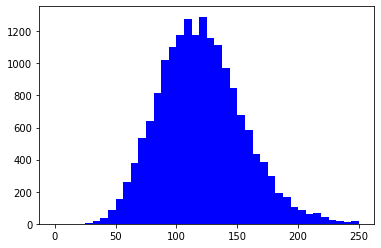

In [75]:
from pylorentz import Momentum4

#Lets compute the mass on the fly
def masscompute(iVec1,iVec2):
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], iVec1[0])
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], iVec2[0])
    return (tau_1+tau_2).m
    
def hmass():
    mask=(reg.array("recohmass") > 0)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg.array(x)[mask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: masscompute(iarr[0:4],iarr[4:8]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

rawmass=hmass()
plt.hist(rawmass,bins=40,range=(0,250),color='blue')

(array([   0.,    0.,    2.,    0.,    6.,    4.,   16.,   21.,   39.,
          62.,  103.,  196.,  266.,  340.,  473.,  657.,  756.,  969.,
        1139., 1242., 1444., 1585., 1572., 1493., 1270.,  896.,  634.,
         407.,  287.,  302.,  214.,  177.,  130.,  117.,   88.,   64.,
          59.,   44.,   27.,   32.]),
 array([  0.  ,   6.25,  12.5 ,  18.75,  25.  ,  31.25,  37.5 ,  43.75,
         50.  ,  56.25,  62.5 ,  68.75,  75.  ,  81.25,  87.5 ,  93.75,
        100.  , 106.25, 112.5 , 118.75, 125.  , 131.25, 137.5 , 143.75,
        150.  , 156.25, 162.5 , 168.75, 175.  , 181.25, 187.5 , 193.75,
        200.  , 206.25, 212.5 , 218.75, 225.  , 231.25, 237.5 , 243.75,
        250.  ]),
 <a list of 40 Patch objects>)

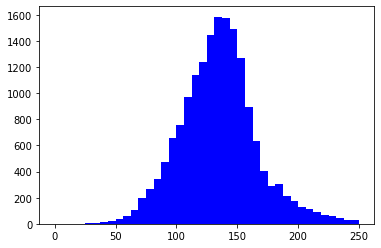

In [76]:
#Lets compute the mass on the fly
def masscomputenn(iVec1,iVec2,iNN):
    pt1 = torch.tensor([iVec1[0]])
    pt2 = torch.tensor([iVec2[0]])
    corr1 = iNN(pt1).data.numpy()*iVec1[0]
    corr2 = iNN(pt2).data.numpy()*iVec2[0]
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr1)
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr2)
    return (tau_1+tau_2).m

#now lets compute the corrected mass on the data set
def hmasscorr(net):
    mask=(reg.array("recohmass") > 0)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg.array(x)[mask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: masscomputenn(iarr[0:4],iarr[4:8],net) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

outmass=hmasscorr(net)
plt.hist(outmass,bins=40,range=(0,250),color='blue')


Plotting 0
Plotting 10
Plotting 20
Plotting 30
Plotting 40


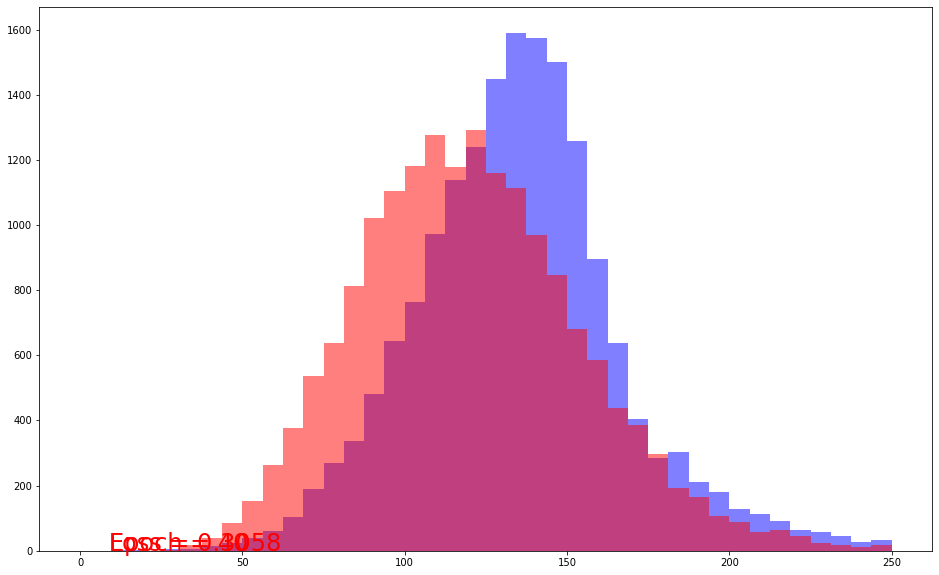

In [77]:
#now lets look at the mass resolution as we train
EPOCH = 50
BATCH_SIZE=100
x=torch.from_numpy(reg.array("recopt1")[mask].reshape(len(reg.array("recopt1")[mask]),1))
y=torch.from_numpy(ratio.reshape(len(ratio),1))
y = Variable(y)
torch_dataset = Data.TensorDataset(x, y)
#loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
# start training
for epoch in range(EPOCH):
    #for step, (batch_x, batch_y) in enumerate(loader):
    #    b_x = Variable(batch_x)
    #    b_y = Variable(batch_y)
    #    prediction = net(b_x)
    #    loss = loss_func(prediction, b_y)
    #    optimizer.zero_grad()
    #    loss.backward()
    #    optimizer.step()
    pred = net(x)
    loss = loss_func(pred, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    if epoch % 10 == 0:
        print("Plotting",epoch)
        # plot and show learning process
        plt.cla()
        outmass=hmasscorr(net)
        ax.hist(outmass,bins=40,range=(0,250),color='blue',alpha=0.5)
        ax.hist(rawmass,bins=40,range=(0,250),color='red',alpha=0.5)
        ax.text(8.8, -0.8, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# save images as a gif    
imageio.mimsave('./massreg1.gif', my_images, fps=12)

In [79]:
#now lets see if we can improve this with something more complicated
net = torch.nn.Sequential(
        torch.nn.Linear(20, 1000),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(1000, 1000),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(1000, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

(array([  17.,  289.,  660.,  861., 1031.,  908.,  935.,  931.,  802.,
         800.,  805.,  676.,  695.,  663.,  589.,  601.,  582.,  498.,
         456.,  431.,  409.,  398.,  307.,  300.,  234.,  233.,  223.,
         205.,  166.,  146.,  150.,  127.,  119.,   84.,   66.,   84.,
          58.,   69.,   63.,   50.]),
 array([  0.  ,   6.25,  12.5 ,  18.75,  25.  ,  31.25,  37.5 ,  43.75,
         50.  ,  56.25,  62.5 ,  68.75,  75.  ,  81.25,  87.5 ,  93.75,
        100.  , 106.25, 112.5 , 118.75, 125.  , 131.25, 137.5 , 143.75,
        150.  , 156.25, 162.5 , 168.75, 175.  , 181.25, 187.5 , 193.75,
        200.  , 206.25, 212.5 , 218.75, 225.  , 231.25, 237.5 , 243.75,
        250.  ]),
 <a list of 40 Patch objects>)

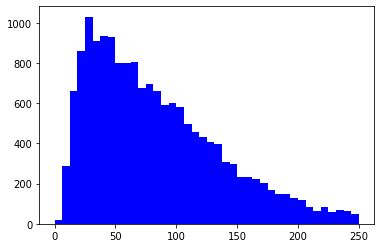

In [80]:
#Lets compute the mass on the fly
def makedataset(iMask,iPart="part1"):
    varlist=[iPart+"pt1",iPart+"eta1",iPart+"phi1",iPart+"id1",iPart+"pt2",iPart+"eta2",iPart+"phi2",iPart+"id2",iPart+"pt3",iPart+"eta3",iPart+"phi3",iPart+"id3",iPart+"pt4",iPart+"eta4",iPart+"phi4",iPart+"id4",iPart+"pt5",iPart+"eta5",iPart+"phi5",iPart+"id5"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg.array(x)[iMask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    return arr

def masscomputennfull(iC1,iC2,iVec1,iVec2):
    corr1 = iC1*iVec1[0]
    corr2 = iC2*iVec2[0]
    tau_1 = Momentum4.m_eta_phi_pt(iVec1[3], iVec1[1], iVec1[2], corr1)
    tau_2 = Momentum4.m_eta_phi_pt(iVec2[3], iVec2[1], iVec2[2], corr2)
    return (tau_1+tau_2).m

#now lets compute the corrected mass on the data set
def hmasscorr(net):
    mask=(reg.array("recohmass") > 0)
    p1=torch.from_numpy(makedataset(mask,"part1"))
    p2=torch.from_numpy(makedataset(mask,"part2"))
    corr1=net(p1)
    corr2=net(p2)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=np.vstack((corr1.data.numpy().T,corr2.data.numpy().T))
    for x in varlist:
        pArr=reg.array(x)[mask]
        arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: masscomputennfull(iarr[0],iarr[1],iarr[2:6],iarr[6:10]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

outmass=hmasscorr(net)
plt.hist(outmass,bins=40,range=(0,250),color='blue')


[1] loss: 3.7493 
[2] loss: 6343450.5000 
[3] loss: 491896.6562 
[4] loss: 110762.5625 
[5] loss: 45725.0703 
[6] loss: 81825.1562 
[7] loss: 42633.8438 
[8] loss: 14270.0693 
[9] loss: 4101.1079 
[10] loss: 839.4529 
[11] loss: 50.5511 
[12] loss: 19.3154 
[13] loss: 69.5486 
[14] loss: 77.9660 
[15] loss: 72.3871 
[16] loss: 66.0565 
[17] loss: 62.2950 
[18] loss: 56.9721 
[19] loss: 44.5589 
[20] loss: 32.5608 
[21] loss: 32.7128 
[22] loss: 37.2737 
[23] loss: 32.6790 
[24] loss: 32.0166 
[25] loss: 38.0452 
[26] loss: 44.9291 
[27] loss: 57.3577 
[28] loss: 70.2439 
[29] loss: 76.3611 
[30] loss: 88.2335 
[31] loss: 89.2727 
[32] loss: 88.6279 
[33] loss: 85.3160 
[34] loss: 74.0189 
[35] loss: 66.2349 
[36] loss: 55.0109 
[37] loss: 44.2934 
[38] loss: 37.4813 
[39] loss: 29.5886 
[40] loss: 23.7954 
[41] loss: 20.5457 
[42] loss: 16.7607 
[43] loss: 13.9212 
[44] loss: 12.7955 
[45] loss: 11.2418 
[46] loss: 9.7208 
[47] loss: 9.1774 
[48] loss: 8.6599 
[49] loss: 7.7967 
[50] l

[413] loss: 0.4016 
[414] loss: 0.4011 
[415] loss: 0.4006 
[416] loss: 0.4001 
[417] loss: 0.3996 
[418] loss: 0.3991 
[419] loss: 0.3986 
[420] loss: 0.3982 
[421] loss: 0.3977 
[422] loss: 0.3972 
[423] loss: 0.3967 
[424] loss: 0.3963 
[425] loss: 0.3958 
[426] loss: 0.3953 
[427] loss: 0.3948 
[428] loss: 0.3944 
[429] loss: 0.3939 
[430] loss: 0.3935 
[431] loss: 0.3930 
[432] loss: 0.3925 
[433] loss: 0.3921 
[434] loss: 0.3916 
[435] loss: 0.3912 
[436] loss: 0.3908 
[437] loss: 0.3903 
[438] loss: 0.3899 
[439] loss: 0.3895 
[440] loss: 0.3890 
[441] loss: 0.3886 
[442] loss: 0.3882 
[443] loss: 0.3877 
[444] loss: 0.3873 
[445] loss: 0.3869 
[446] loss: 0.3865 
[447] loss: 0.3860 
[448] loss: 0.3856 
[449] loss: 0.3852 
[450] loss: 0.3848 
[451] loss: 0.3844 
[452] loss: 0.3840 
[453] loss: 0.3836 
[454] loss: 0.3832 
[455] loss: 0.3828 
[456] loss: 0.3824 
[457] loss: 0.3820 
[458] loss: 0.3817 
[459] loss: 0.3813 
[460] loss: 0.3809 
[461] loss: 0.3806 
[462] loss: 0.3802 


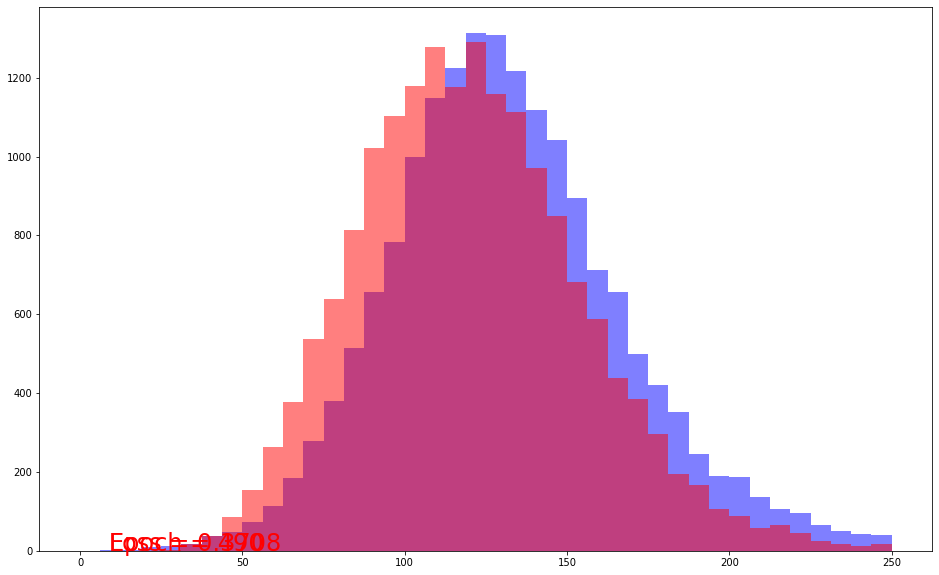

In [81]:
mask1=(reg.array("genpt1") > 0)
mask2=(reg.array("recopt1") > 0)
mask = np.logical_and.reduce([mask1,mask2])
#y=torch.from_numpy(reg.array("genpt1")[mask].reshape(len(reg.array("genpt1")[mask]),1))
y=torch.from_numpy(ratio.reshape(len(ratio),1))
y = Variable(y)
history_lr = {'loss':[], 'val_loss':[]}

EPOCH = 500
x=torch.from_numpy(makedataset(mask))
x,y = Variable(x),Variable(y)
torch_dataset = Data.TensorDataset(x, y)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))
for epoch in range(EPOCH):
    pred = net(x)
    loss = loss_func(pred, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    with torch.no_grad():#disable updating gradient
            print('[%d] loss: %.4f ' % (epoch + 1, loss ))
            history_lr['loss'].append(loss)
            
    if epoch % 10 == 0:
        #print("Plotting",epoch)
        plt.cla()
        outmass=hmasscorr(net)
        ax.hist(outmass,bins=40,range=(0,250),color='blue',alpha=0.5)
        ax.hist(rawmass,bins=40,range=(0,250),color='red',alpha=0.5)
        ax.text(8.8, -0.8, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)

# save images as a gif    
imageio.mimsave('./massreg2.gif', my_images, fps=12)


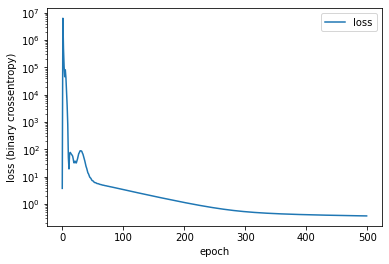

In [83]:
plt.semilogy(history_lr['loss'], label='loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.show()

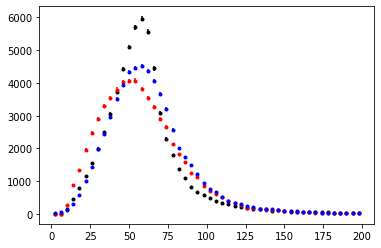

In [85]:
def plotcorr(iVar,iNN,iMin,iMax,iColor): 
    mask=(reg.array(iVar) > 0)
    p1=torch.from_numpy(makedataset(mask,"part1"))
    corr1=net(p1)
    data=reg.array(iVar)[mask]
    data=data*corr1.data.numpy().T
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    plt.errorbar(binCenters, counts, yerr=err,fmt="o",c=iColor,label="Data", ms=3)
    
plot("genpt1",0,200,"black")
plot("recopt1",0,200,"red")
plotcorr("recopt1",net,0,200,"blue")


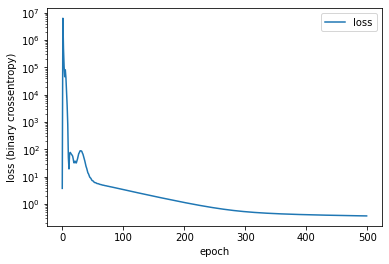

In [82]:
plt.semilogy(history_lr['loss'], label='loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss (binary crossentropy)')
plt.show()

In [101]:
#now lets define a RNN
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out,h = self.gru(x,h)
        out = self.fc(self.relu(out[:,-1]))
        return out,h 
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        #torch.zeros(1, 1, self.hidden_size, device=device)
        return hidden

model  = GRUNet(5, 256, 1, 5)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [132]:
def makedatasetrnn(iMask,iPart="part1"):
    varlist=[iPart+"pt1",iPart+"eta1",iPart+"phi1",iPart+"id1",iPart+"pt2",iPart+"eta2",iPart+"phi2",iPart+"id2",iPart+"pt3",iPart+"eta3",iPart+"phi3",iPart+"id3",iPart+"pt4",iPart+"eta4",iPart+"phi4",iPart+"id4",iPart+"pt5",iPart+"eta5",iPart+"phi5",iPart+"id5"]
    arr=0
    idx=0
    for x in varlist:
        pArr=reg.array(x)[iMask]
        if idx == 0: 
            arr = pArr
            idx = idx + 1
        else:
            arr=np.vstack((arr,pArr))
    arr = arr.T
    return arr.reshape(len(arr),5,4)

mask1=(reg.array("genpt1") > 0)
mask2=(reg.array("recopt1") > 0)
mask = np.logical_and.reduce([mask1,mask2])
x=torch.from_numpy(makedatasetrnn(mask))

(array([0.000e+00, 1.100e+01, 1.040e+02, 3.450e+02, 7.730e+02, 1.310e+03,
        1.993e+03, 2.327e+03, 2.509e+03, 2.425e+03, 1.886e+03, 1.320e+03,
        9.470e+02, 5.700e+02, 3.200e+02, 1.790e+02, 1.320e+02, 6.300e+01,
        4.700e+01, 3.100e+01, 1.800e+01, 1.200e+01, 1.000e+01, 5.000e+00,
        3.000e+00, 4.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00]),
 array([  0.  ,   6.25,  12.5 ,  18.75,  25.  ,  31.25,  37.5 ,  43.75,
         50.  ,  56.25,  62.5 ,  68.75,  75.  ,  81.25,  87.5 ,  93.75,
        100.  , 106.25, 112.5 , 118.75, 125.  , 131.25, 137.5 , 143.75,
        150.  , 156.25, 162.5 , 168.75, 175.  , 181.25, 187.5 , 193.75,
        200.  , 206.25, 212.5 , 218.75, 225.  , 231.25, 237.5 , 243.75,
        250.  ]),
 <a list of 40 Patch objects>)

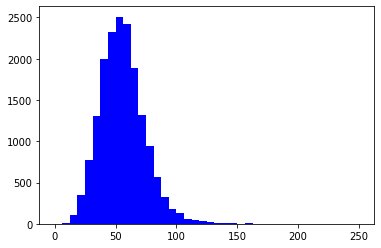

In [146]:
#now lets compute the corrected mass on the data set
def hmasscorrrnn(net):
    mask=(reg.array("recohmass") > 0)
    p1=torch.from_numpy(makedatasetrnn(mask,"part1"))
    p2=torch.from_numpy(makedatasetrnn(mask,"part2"))
    corr1=net(p1)
    corr2=net(p2)
    varlist=["recopt1","recoeta1","recophi1","recomass1","recopt2","recoeta2","recophi2","recomass2"]
    arr=np.vstack((corr1.data.numpy().T,corr2.data.numpy().T))
    for x in varlist:
        pArr=reg.array(x)[mask]
        arr=np.vstack((arr,pArr))
    arr = arr.T
    massc = lambda iarr: masscomputennfull(iarr[0],iarr[1],iarr[2:6],iarr[6:10]) 
    hmasses = np.array([massc(p) for p in arr])
    return hmasses

outmass=hmasscorr(lstm)
plt.hist(outmass,bins=40,range=(0,250),color='blue')

[1] loss: 2.2222 
[2] loss: 1.3640 
[3] loss: 0.6249 
[4] loss: 0.5121 
[5] loss: 0.5973 
[6] loss: 0.4039 
[7] loss: 0.3363 
[8] loss: 0.3740 
[9] loss: 0.4029 
[10] loss: 0.3871 
[11] loss: 0.3469 
[12] loss: 0.3173 
[13] loss: 0.3217 
[14] loss: 0.3455 
[15] loss: 0.3511 
[16] loss: 0.3333 
[17] loss: 0.3147 
[18] loss: 0.3117 
[19] loss: 0.3178 
[20] loss: 0.3229 
[21] loss: 0.3224 
[22] loss: 0.3172 
[23] loss: 0.3114 
[24] loss: 0.3081 
[25] loss: 0.3084 
[26] loss: 0.3098 
[27] loss: 0.3092 
[28] loss: 0.3080 
[29] loss: 0.3071 
[30] loss: 0.3063 
[31] loss: 0.3053 
[32] loss: 0.3041 
[33] loss: 0.3026 
[34] loss: 0.3011 
[35] loss: 0.3004 
[36] loss: 0.3007 
[37] loss: 0.2990 
[38] loss: 0.2970 
[39] loss: 0.2958 
[40] loss: 0.2943 
[41] loss: 0.2908 
[42] loss: 0.2868 
[43] loss: 0.2888 
[44] loss: 0.2827 
[45] loss: 0.2782 
[46] loss: 0.2741 
[47] loss: 0.2718 
[48] loss: 0.2692 
[49] loss: 0.2664 
[50] loss: 0.2635 


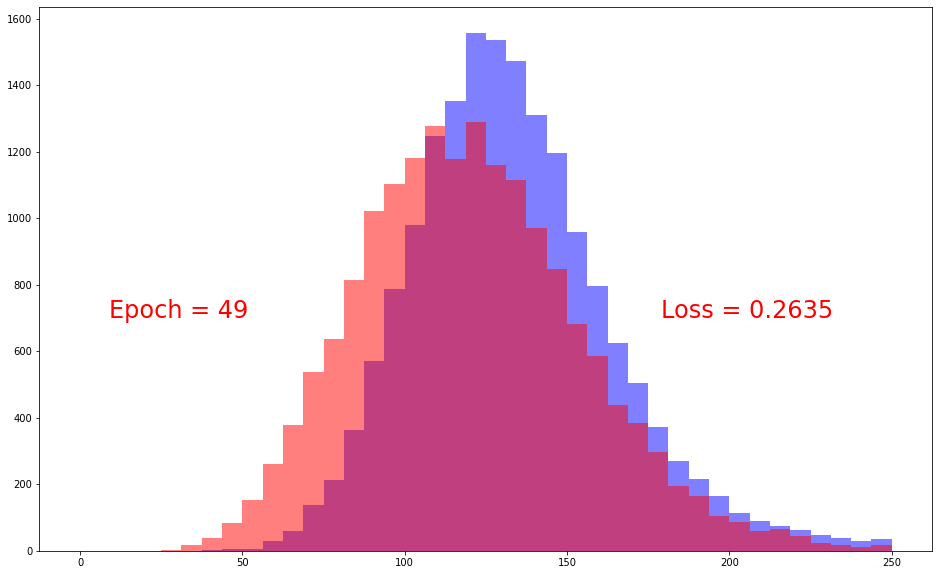

In [165]:
batch_size=len(x)
history_lr = {'loss':[], 'val_loss':[]}
EPOCH = 50
y=torch.from_numpy(ratio.reshape(len(ratio),1))
mask1=(reg.array("genpt1") > 0)
mask2=(reg.array("recopt1") > 0)
mask = np.logical_and.reduce([mask1,mask2])
x,y = Variable(x),Variable(y)

torch_dataset = Data.TensorDataset(x, y)
my_images = []
fig, ax = plt.subplots(figsize=(16,10))

input_size = 4
hidden_size = 128
num_layers = 1
num_classes = 1
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

lstm.train()
for epoch in range(EPOCH):
    #h      = lstm.init_hidden(batch_size)
    pred = lstm(x)
    loss = criterion(pred, y) 
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    with torch.no_grad():#disable updating gradient
            print('[%d] loss: %.4f ' % (epoch + 1, loss ))
            history_lr['loss'].append(loss)
            
    if epoch % 1 == 0:
        #print("Plotting",epoch)
        plt.cla()
        outmass=hmasscorrrnn(lstm)
        ax.hist(outmass,bins=40,range=(0,250),color='blue',alpha=0.5)
        ax.hist(rawmass,bins=40,range=(0,250),color='red',alpha=0.5)
        ax.text(8.8, 700, 'Epoch = %d' % epoch,fontdict={'size': 24, 'color':  'red'})
        ax.text(178.8, 700, 'Loss = %.4f' % loss.data.numpy(),fontdict={'size': 24, 'color':  'red'})
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image  = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        my_images.append(image)
imageio.mimsave('./massreg3_lstm.gif', my_images, fps=12)

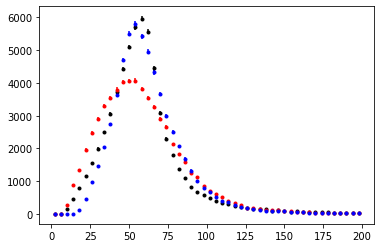

In [166]:
def plotcorr(iVar,iNN,iMin,iMax,iColor): 
    mask=(reg.array(iVar) > 0)
    p1=torch.from_numpy(makedatasetrnn(mask,"part1"))
    corr1=iNN(p1)
    data=reg.array(iVar)[mask]
    data=data*corr1.data.numpy().T
    counts, binEdges = np.histogram(data,bins=50,range=(iMin,iMax),density=False)
    binCenters = (binEdges[1:]+binEdges[:-1])*.5
    err = np.sqrt(counts)
    plt.errorbar(binCenters, counts, yerr=err,fmt="o",c=iColor,label="Data", ms=3)
    
plot("genpt1",0,200,"black")
plot("recopt1",0,200,"red")
plotcorr("recopt1",lstm,0,200,"blue")

In [116]:
!curl -o airline-passengers.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2180  100  2180    0     0    352      0  0:00:06  0:00:06 --:--:--   529


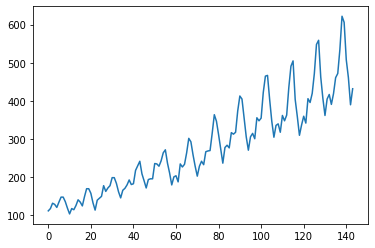

In [118]:
import pandas as pd
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Shampoo Sales Data')
plt.show()

In [122]:
from sklearn.preprocessing import MinMaxScaler
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 10
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print(testX.shape,testY.shape)

torch.Size([44, 10, 1]) torch.Size([44, 1])


In [156]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 20)
        self.fc2 = nn.Linear(20, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)
        out = F.relu(out)
        out = self.fc2(out)
        return out


In [157]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

print(trainX.shape)
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

torch.Size([89, 10, 1])
Epoch: 0, loss: 0.04876
Epoch: 100, loss: 0.00331
Epoch: 200, loss: 0.00243
Epoch: 300, loss: 0.00202
Epoch: 400, loss: 0.00195
Epoch: 500, loss: 0.00185
Epoch: 600, loss: 0.00170
Epoch: 700, loss: 0.00164
Epoch: 800, loss: 0.00158
Epoch: 900, loss: 0.00154
Epoch: 1000, loss: 0.00151
Epoch: 1100, loss: 0.00167
Epoch: 1200, loss: 0.00151
Epoch: 1300, loss: 0.00144
Epoch: 1400, loss: 0.00139
Epoch: 1500, loss: 0.00142
Epoch: 1600, loss: 0.00136
Epoch: 1700, loss: 0.00135
Epoch: 1800, loss: 0.00130
Epoch: 1900, loss: 0.00128


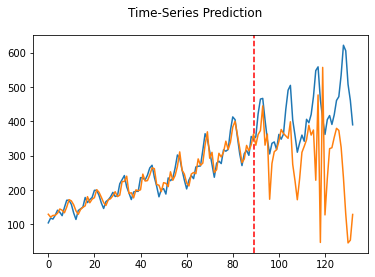

In [158]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

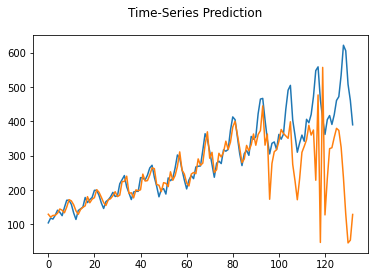

In [167]:
plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

This is some text $f^{n}(x)$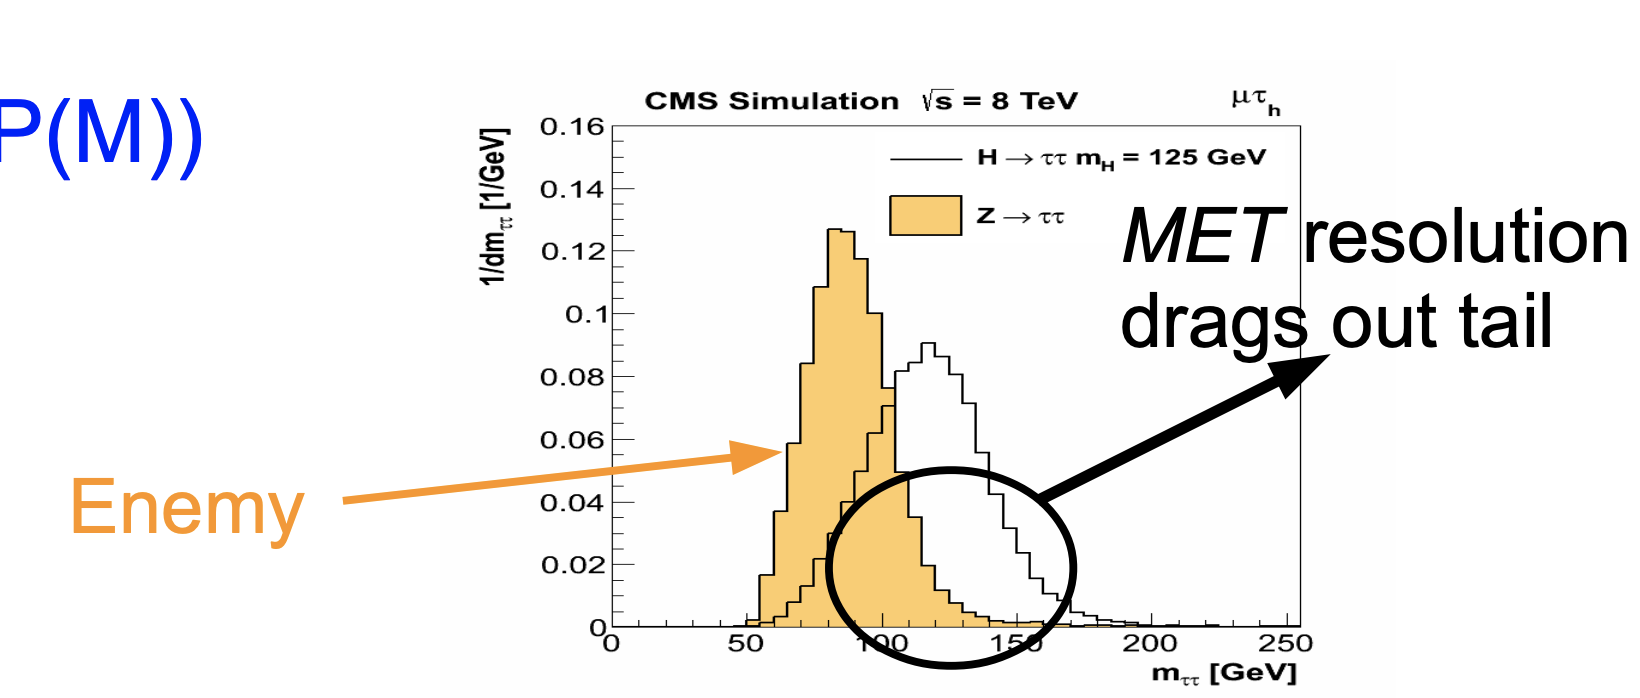